
## A Neural Network to Predict NCAA Men's Basketball Tournament Brackets

#### Bernard Chang
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

The NCAA Men's Basketball Tournament (colloquially known as March Madness) is an annual tournament that crowns the best team in college basketball. Every year, millions of people complete a tournament bracket, in which they pick who they believe will win every matchup starting from a 64 team field. Statistically, the likelihood of completing a perfect bracket by randomly selecting winners 1 in 9.2 quintillion. 

Here, I propose a workflow to train a model to make predictions based on selected input features. For this draft, I establish a baseline model using logistic regression and win/loss ratio, point differentials, and seeding as predictor features to try to predict the winner of each tournament matchup. With some hyperparameter tuning, the model was able to predict 92/134 matchups from 2019, translating to an F1-score of 0.687. The next iteration of this model will include more input features, including box-scores (e.g., assists, rebounds, turnovers, etc.) and advanced statistics (e.g. offensive/defensive rating, pace, etc.) to try to improve this model. Of course, this will require some feature selection, which will be shown in the next draft.

### Import Packages

In [1]:
# System packages
import os

# Data structures, IO, and matrix manipulation packages
import pandas as pd
import numpy as np


# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns

# ML Packages
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix





### Functions

In [2]:
##################################################################
# A function that performs splitting training and validation split, 
# then standardizes the predictor features
# Inputs= Training dataset, features, and year to split (Default 2015)
# Returns= Train_x, train_y: Predictor and response features from year_to_split to 2018
##################################################################

def train_split(data_df, features, year_to_split=2015):
    seasons = data_df['Season'].unique()
    
    std_scaler = StandardScaler()
    
    train_x = data_df.loc[data_df['Season'] >= year_to_split , features]
    train_x = train_x.loc[data_df['Season'] < 2019 , features]
    
    train_y = data_df.loc[data_df['Season'] >= year_to_split, ['Win_A']]
    train_y = train_y.loc[data_df['Season'] < 2019, ['Win_A']].to_numpy().ravel()
    train_x = std_scaler.fit_transform(train_x)
    
    return train_x, train_y, std_scaler

### Load Data

The following workflow uses data that is openly available for the "March Machine Learning Mania 2021 - NCAAM" competition on [kaggle.com](https://www.kaggle.com/c/ncaam-march-mania-2021/data). Details of the datasets are contained in the "Data" landing page. The features I will use are summarized below. 

The raw dataset is split into two "stages." Stage 1 contains NCAA Men's Basketball data from 1985-2020 and Stage 2 contains the same sets of data for the 2021 season. For the first iteration of this workflow, we will establish a baseline model prediction using the win-loss and margin of victory/loss for each tournament team.

For the baseline model, I will fit a logistic regression model to find the likelihood of a team winning its tournament matchup. The next draft will include more comprehensive feature selection and model training with more complex input features.

Here, I will load precompiled data. For details on how the data was compiled from across multiple files, please see the ```data_compilation.ipynb``` file in my GitHub repository (. 

The column headings of the dataset are as follows:
* ```Season``` - Season the game was played (year)
* ```DayNum``` - Days after the first day of the season the game was played, gives information for the tournament round (days)
* ```Team_A(B)``` - ID label for Team A(B)
* ```Score_A(B)``` - Number of points scored by Team A(B)
* ```Seed_A(B)``` - Tournament seed for Team A(B)
* ```mean_WScore_A(B)``` - Mean number of points scored by Team A(B) when Team A(B) wins
* ```mean_LScore_A(B)``` - Mean number of points scored by Team A(B) when Team A(B) loses
* ```WL_A(B)``` - Win-Loss Ratio for Team A(B)
* ```Point_Diff_A(B)``` - Total point different for Team A(B)


The features that will be used in the first iteration of this workflow are as follows:


* **Tournament Seeds** - Tournment seeding for each team, for each year, as determined by the NCAA tournament selection committee; unitless
* **Winning score** - Average number of points scored in a win ; points
* **Losing score** - Average number of points scored in a  loss ; points
* **Win ratio** - Number of games won / Total number of games played ; fraction
* **Score Gap** - Cumulative margin of victory - Cumulative margin of loss, normalized by total number of games played; points/game
* **Score Gap Differential** Difference in score gap between the two teams in the tournament matchup ; points/game
* **Win Ratio Differential** Difference in win ratio between the two teams in the tournament matchup ; fraction


There are two datasets contained in the repository. The first is the training dataset I compiled with the above features. The second is the validation dataset provided in the Kaggle competition; however I manipulated the dataset to include the same features as the training set. 

In [3]:
repo_data_path = 'https://raw.githubusercontent.com/BC-Chang/predict-march-madness/master/draft1_data'

train = pd.read_csv(f'{repo_data_path}/training_dataset.csv')
test = pd.read_csv(f'{repo_data_path}/validation_dataset.csv')

train.head()

,Season,DayNum,Team_A,Score_A,Team_B,Score_B,Seed_A,Seed_B,mean_WScore_A,mean_LScore_A,WL_A,Point_Diff_A,mean_WScore_B,mean_LScore_B,WL_B,Point_Diff_B,Win_A,SeedDiff,PD_Diff,WL_Diff
0,1985,136,1116,63,1234,54,9,8,68.952381,59.000000,0.636364,22.424242,76.250000,56.700000,0.666667,31.933333,1,1,-9.509091,-0.030303
1,1985,136,1120,59,1345,58,11,6,72.666667,66.545455,0.620690,19.862069,70.058824,67.125000,0.680000,26.160000,1,5,-6.297931,-0.059310
2,1985,136,1207,68,1250,43,1,16,76.680000,64.000000,0.925926,66.259259,74.727273,60.277778,0.379310,-9.068966,1,-15,75.328225,0.546616
3,1985,136,1229,58,1425,55,9,8,74.200000,64.142857,0.740741,38.333333,72.947368,58.777778,0.678571,30.607143,1,1,7.726190,0.062169
4,1985,136,1242,49,1325,38,3,14,78.652174,67.428571,0.766667,44.566667,67.450000,67.857143,0.740741,32.370370,1,-11,12.196296,0.025926


In [4]:
test.head(5)

,ID,Pred,Season,TeamID_A,TeamID_B,Seed_A,Seed_B,SeedDiff,mean_WScore_A,mean_LScore_A,WL_A,Point_Diff_A,mean_WScore_B,mean_LScore_B,WL_B,Point_Diff_B,PD_Diff,WL_Diff
0,2015_1107_1112,0.5,2015,1107,1112,14,2,12,67.791667,58.625,0.75,36.1875,77.354839,67.000000,0.911765,64.617647,-28.430147,-0.161765
1,2015_1107_1116,0.5,2015,1107,1116,14,5,9,67.791667,58.625,0.75,36.1875,80.615385,69.625000,0.764706,45.264706,-9.077206,-0.014706
2,2015_1107_1124,0.5,2015,1107,1124,14,3,11,67.791667,58.625,0.75,36.1875,73.304348,58.444444,0.718750,36.250000,-0.062500,0.031250
3,2015_1107_1125,0.5,2015,1107,1125,14,15,-1,67.791667,58.625,0.75,36.1875,77.000000,67.000000,0.677419,30.548387,5.639113,0.072581
4,2015_1107_1129,0.5,2015,1107,1129,14,11,3,67.791667,58.625,0.75,36.1875,74.043478,57.875000,0.741935,40.000000,-3.812500,0.008065


### Data Preprocessing

Before training our model, we should examine our data. This includes looking at summary statistics, visualization, and any data cleaning if necessary. For the next draft, I will include more features, so some multivariate analysis will be included as well as feature selection. 

#### Summary Statistics

This step is used to ensure we don't have any missing data that we would need to perform list_wise deletion on. 
It is also useful to compare wins and losses, and training and validation datasets

##### Training Dataset

Here we see 4502 data entries for the training set. This is common across all columns indicating that we do not have missing data. The features of interest seem to operate on appear to operate on different scales, so some normalization/standardization procedure will be necessary. 

In [5]:
train.describe()

,Season,DayNum,Team_A,Score_A,Team_B,Score_B,Seed_A,Seed_B,mean_WScore_A,mean_LScore_A,WL_A,Point_Diff_A,mean_WScore_B,mean_LScore_B,WL_B,Point_Diff_B,Win_A,SeedDiff,PD_Diff,WL_Diff
count,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4.502000e+03,4.502000e+03
mean,2002.223456,139.139049,1289.559085,71.085073,1289.559085,71.085073,6.835184,6.835184,79.218436,67.653920,0.750061,42.737024,79.218436,67.653920,0.750061,42.737024,0.500000,0.000000,4.126419e-15,4.164569e-17
std,10.138490,4.210601,102.021337,12.884171,102.021337,12.884171,4.625589,4.625589,6.578625,7.719456,0.101531,16.203120,6.578625,7.719456,0.101531,16.203120,0.500056,7.535563,2.418920e+01,1.512531e-01
min,1985.000000,134.000000,1101.000000,29.000000,1101.000000,29.000000,1.000000,1.000000,60.300000,0.000000,0.357143,-15.428571,60.300000,0.000000,0.357143,-15.428571,0.000000,-15.000000,-1.017879e+02,-6.333333e-01
25%,1993.000000,136.000000,1210.000000,62.000000,1210.000000,62.000000,3.000000,3.000000,74.911765,63.333333,0.678571,31.357143,74.911765,63.333333,0.678571,31.357143,0.000000,-5.000000,-1.539435e+01,-9.847656e-02
50%,2002.000000,137.000000,1278.000000,71.000000,1278.000000,71.000000,6.000000,6.000000,78.653846,67.400000,0.750000,42.281250,78.653846,67.400000,0.750000,42.281250,0.500000,0.000000,0.000000e+00,0.000000e+00
75%,2011.000000,139.000000,1386.000000,79.000000,1386.000000,79.000000,11.000000,11.000000,82.954545,71.800000,0.821429,53.448085,82.954545,71.800000,0.821429,53.448085,1.000000,5.000000,1.539435e+01,9.847656e-02
max,2019.000000,154.000000,1463.000000,149.000000,1463.000000,149.000000,16.000000,16.000000,126.347826,117.800000,1.000000,100.733333,126.347826,117.800000,1.000000,100.733333,1.000000,15.000000,1.017879e+02,6.333333e-01


##### Test Dataset
We get the same summary statistics as for the training dataset. We see that statistics for the features of interest are comparable between the testing and training datasets. 

The counts of the data columns are consistent, meaning we are not missing data. The reason why the counts for the testing dataset are significantly higher than that of the training dataset is because the testing dataset contains game-by-game statistics between two teams, whereas the training set contains the average for each team over the entire season/tournament.

In [6]:
test.describe()

,Pred,Season,TeamID_A,TeamID_B,Seed_A,Seed_B,SeedDiff,mean_WScore_A,mean_LScore_A,WL_A,Point_Diff_A,mean_WScore_B,mean_LScore_B,WL_B,Point_Diff_B,PD_Diff,WL_Diff
count,11390.0,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000
mean,0.5,2017.000000,1236.486128,1358.525637,8.826602,8.761633,0.064969,78.881415,67.393530,0.719949,37.980492,78.017534,66.605283,0.724189,38.124145,-0.143653,-0.004240
std,0.0,1.414276,88.035207,82.661731,4.738361,4.588366,6.644729,5.110269,6.829468,0.100851,15.290823,5.265736,6.412328,0.102011,15.287520,21.681920,0.143937
min,0.5,2015.000000,1101.000000,1112.000000,1.000000,1.000000,-15.000000,64.280000,0.000000,0.424242,-5.454545,64.280000,0.000000,0.424242,-5.454545,-70.790553,-0.515152
25%,0.5,2016.000000,1159.000000,1300.000000,5.000000,5.000000,-5.000000,75.350000,64.250000,0.656250,28.333333,74.157895,62.875000,0.645161,26.129032,-15.230221,-0.104779
50%,0.5,2017.000000,1234.000000,1374.000000,9.000000,9.000000,0.000000,78.800000,67.461538,0.718750,38.030303,77.800000,66.166667,0.727273,38.333333,-0.061553,0.000000
75%,0.5,2018.000000,1300.000000,1433.000000,13.000000,12.000000,5.000000,82.350000,71.000000,0.781250,48.031250,81.791667,70.500000,0.800000,48.687500,14.765029,0.093750
max,0.5,2019.000000,1462.000000,1463.000000,16.000000,16.000000,15.000000,93.833333,84.750000,1.000000,80.272727,93.833333,84.750000,1.000000,80.272727,74.803977,0.469697


#### Data Visualization

Here we visualize the data to better evaluate the relationships between features.

I also confirm that the training dataset is an appropriate representation of the validation dataset.

Here, I visualize the difference in point differentials and the difference in WL ratio. We see that both are approximately normally distributed with a mean close to 0. 

I also plot the difference in win-loss to the difference in point differential to confirm the intuitive belief that win-loss ratios monotonically increase as a team's average point differential increases.

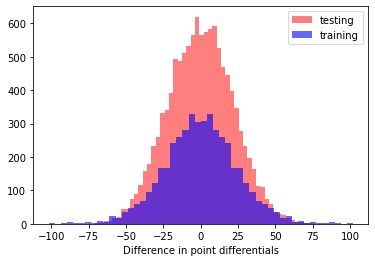

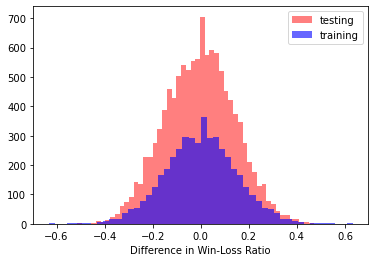

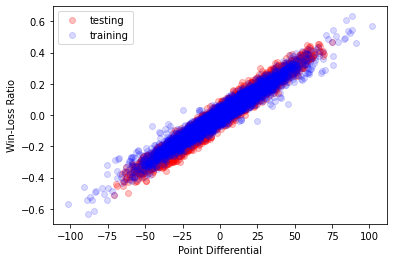

In [7]:
plt.figure()

plt.hist(test['PD_Diff'],  bins=50, alpha=0.5, color='r', label='testing')
plt.hist(train['PD_Diff'],  bins=50, alpha=0.6, color='b', label='training')
plt.xlabel('Difference in point differentials')
plt.legend()

plt.figure()
plt.hist(test['WL_Diff'],  bins=50, alpha=0.5, color='r', label='testing')
plt.hist(train['WL_Diff'],  bins=50, alpha=0.6, color='b', label='training')
plt.xlabel('Difference in Win-Loss Ratio')
plt.legend()

plt.figure()
plt.plot(test['PD_Diff'], test['WL_Diff'], 'or', alpha=0.25, label='testing')
plt.plot(train['PD_Diff'], train['WL_Diff'], 'ob', alpha=0.15, label='training')
plt.ylabel('Win-Loss Ratio')
plt.xlabel('Point Differential')
plt.legend()

Here I compare the mean number of points a team scores in a win between the training and validation data. Both are approximately normally distributed and centered around the same mean. There are very few obvious gaps in the validation dataset. and the training set is sufficiently complete. 

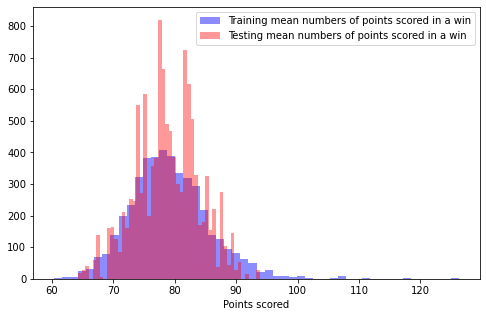

In [8]:
plt.figure(figsize=(8,5))
plt.hist(train['mean_WScore_A'], bins=50, alpha=0.45, color='b', label='Training mean numbers of points scored in a win')
plt.hist(test['mean_WScore_A'], bins=50, alpha=0.4, color='r', label='Testing mean numbers of points scored in a win')
plt.xlabel('Points scored')
plt.legend()

Finally, I analyze the performance of teams based solely on their seedings. We see here that higher seeded teams (lower seed numbers) generally have higher win percentages. The assignment of a team's seed is known to be a somewhat biased process by the NCAA selection committee. They account for extra metrics not shown here such as the team's strength of schedule, the conference they play in, and even historical factors when making their assignments.

From the histogram, we also see that higher seeded teams generally win more games in the tournament than lower seeded teams. 

Text(0.5, 0, 'Winning Seed')

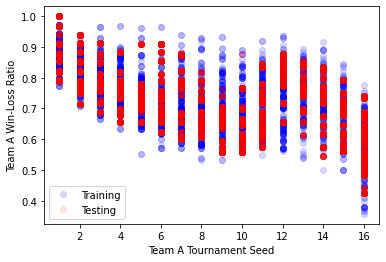

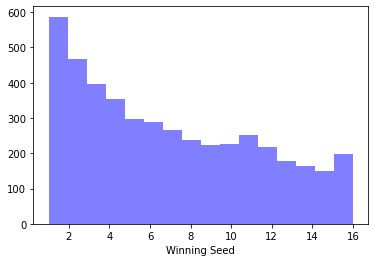

In [9]:
plt.plot(train['Seed_A'], train['WL_A'], 'ob', alpha=0.15, label='Training')
plt.plot(test['Seed_A'], test['WL_A'], 'ro', alpha=0.1, label='Testing')
plt.xlabel('Team A Tournament Seed')
plt.ylabel('Team A Win-Loss Ratio')
plt.legend()

plt.figure()
plt.hist(train['Seed_A'], bins=16, color='b', alpha=0.5, label='Winning Seed')
plt.xlabel('Winning Seed')

### Feature Selection

In my next draft, I will include more input features including the team's box score statistics (e.g., points, assists, rebounds, shooting percentage, etc.) as well as some advanced statistics (offensive/defensive rating, pace of play, assist/turnover ratio etc.) As such, I will also perform feature selection to identify and keep the features that maximize the variance explained while not adding too much complexity to the model.

### Logistic Regression

As a first pass and to establish a baseline, I will use logistic regression to calculate the probability of a team winning its matchup based on the input features outline above. 

Logistic Regression is useful for classifying categorical. In our case, we can classify the team as a win or a loss for its matchup based on the features. It's flexible in that it can take in any number of input features and also has some built-in feature selection, similar to LASSO regression.

First, we initialize our prediction structures


In [10]:
seasons = train['Season'].unique()
features = [
    'Seed_A',
    'Seed_B',
    'WL_A',
    'Point_Diff_A',
    'WL_B',
    'Point_Diff_B',
    'PD_Diff',
    'WL_Diff',
    'SeedDiff'
    ]

# Season to validate on
val_season = 2019

# Seed for initializing random state of logistic regression
SEED = 110

# Train with all data after and including season_split
season_split = 2000

# Our logistic regression model
model = LogisticRegression(C=1, random_state=SEED, solver='saga') #C=10

# Retrieve training data
train_X, train_Y, std_scaler = train_split(train, features, season_split)

# Fit the model to training data
model.fit(train_X, train_Y)

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]

# Predicted 2019 outcome
y_hat = model.predict(val_X)

# Store f_score in a list
f_score = [val_season, f1_score(val_Y, y_hat)]

print(f'{f_score[0]} F1-Score: {f_score[1]}')

2019 F1-Score: 0.6567164179104478


### Tune Hyperparameters

Some hyperparameters we can play with for this problem are the amount of training data, the regularization term (l1, l2), and inverse of the regularization strength (C). I will look at each individually.

#### Amount of Training Data
In the first example, we trained with all data since the year 2000. In sports, historical data is not necessarily the best predictor of the modern game as play style, tactics, and other factors change throughout time.

Here I compare the calculated F1-Scores after using cumulative data, going backwards in time from year 2018. We see that using data from year 2017 onward, we get a jump in F1-Score, so we will use 2017 as the split year moving forward. 

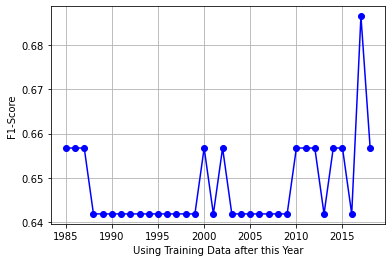

In [11]:
seasons2split = np.arange(1985, 2019, 1)
random_seed = 1284

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]

f_score = []

for season_split in seasons2split:
    
    # Our logistic regression model
    model = LogisticRegression(C=1, random_state=random_seed, solver='saga')

    # Retrieve training data
    train_X, train_Y, std_scaler = train_split(train, features, season_split)

    # Fit the model to training data
    model.fit(train_X, train_Y)

    # Predicted 2019 outcome
    y_hat = model.predict(val_X)

    # Store f_score in a list
    f_score.append([season_split, f1_score(val_Y, y_hat)])

f_score = np.array(f_score)

plt.plot(f_score[:,0], f_score[:,1], 'o-b')
plt.xlabel('Using Training Data after this Year')
plt.ylabel('F1-Score')
plt.grid()

#### Regularization Term
In the first example, we used the default L2 regularization term. 

Regularization applies a penalty to increasing the magnitude of a parameter. This helps reduce overfitting. Similar to Ridge and LASSO regression, Logistic regression also uses l1 and l2 norms as regularization terms. Here we try different regularization terms, including no regularization, l1, l2, and a combination of l1 and l2 (elasticnet). We use 2007 as our season split as described above.

From the plot, we see that we get the best performance using the l2 norm as the regularization term.

Text(0, 0.5, 'F1-Score')

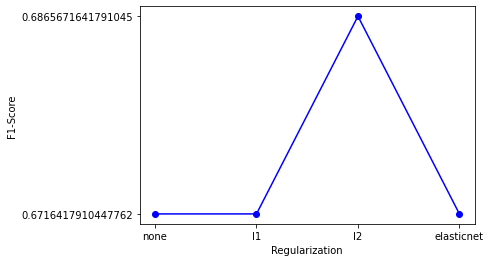

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Regularization terms to try
reg_term = ['none','l1','l2','elasticnet']

random_seed = 1284

# Train with all data prior to and including season_split
season_split = 2017

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]

f_score = []

for regularization in reg_term:
    
    # Our logistic regression model
    model = LogisticRegression(C=1, random_state=random_seed, penalty=regularization, solver='saga', l1_ratio=0.8, max_iter=1000)

    # Retrieve training data
    train_X, train_Y, std_scaler = train_split(train, features, season_split)

    # Fit the model to training data
    model.fit(train_X, train_Y)

    # Predicted 2019 outcome
    y_hat = model.predict(val_X)

    # Store f_score in a list
    f_score.append([regularization, f1_score(val_Y, y_hat)])

# f_score
f_score = np.array(f_score)

plt.plot(f_score[:,0], f_score[:,1], 'o-b')
plt.xlabel('Regularization')
plt.ylabel('F1-Score')

#### Inverse of regularization strength

Here we vary ```C```, the inverse of the regularization strength. This is similar to the lambda term used in Ridge and LASSO regression. Smaller values specify stronger regularization.

From the plot, we see that an inverse regularization strength between 0.3 and 1 maximizes the F1-Score. Therefore, I will use an inverse regularization strength of 0.8

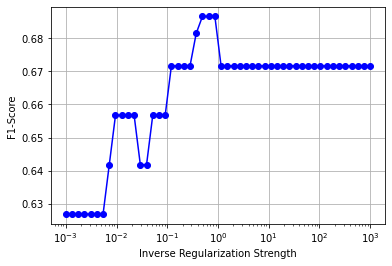

In [21]:
reg_strength = np.logspace(-3,3, 50)

random_seed = 1284

# Train with all data prior to and including season_split
season_split = 2017

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]
f_score = []

for c in reg_strength:
    
    # Our logistic regression model
    model = LogisticRegression(C=c, random_state=random_seed, penalty='l2', solver='saga')

    # Retrieve training data
    train_X, train_Y, std_scaler = train_split(train, features, season_split)
    
    # Fit the model to training data
    model.fit(train_X, train_Y)



    # Predicted 2019 outcome
    y_hat = model.predict(val_X)

    # Store f_score in a list
    f_score.append([c, f1_score(val_Y, y_hat)])

f_score = np.array(f_score)

plt.semilogx(f_score[:,0], f_score[:,1], 'o-b')
plt.xlabel('Inverse Regularization Strength')
plt.ylabel('F1-Score')
plt.grid()

### Final Model

We retrain our model with the tuned hyperparameters to get our final model. From our validation prediction, we get a final F1-Score of 0.687. This is not bad considering the small number of features we are using to train the model.


In [22]:
# Seed for initializing random state of logistic regression
SEED = 1285

# Train with all data prior to and including season_split
season_split = 2017

# Our logistic regression model
model = LogisticRegression(C=0.8, random_state=SEED, penalty='l2', solver='saga')

# Retrieve training data
train_X, train_Y, std_scaler = train_split(train, features, season_split)

# Fit the model to training data
model.fit(train_X, train_Y)


# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]

# Predicted 2019 outcome
y_hat = model.predict(val_X)

# Store f_score in a list
f_score = [val_season, f1_score(val_Y, y_hat)]
print(f'{f_score[0]} F1-Score: {f_score[1]}')

2019 F1-Score: 0.6865671641791045


### Results

Our final validation prediction had an F1-Score of 0.687. This is not bad considering the model only had basic features to fit. In the future, I will include more features, including basic box-score statistics and more advanced statistics. Of course, this will require some feature selection and more hyperparameter tuning. 

From the confusion matrix, we see that the logistic regression correctly predicted 92 out of 132 matchups. This is a good baseline for future models.

[[46 21]
 [21 46]]


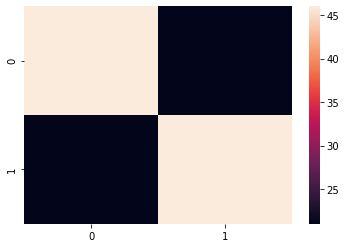

In [23]:
cm = confusion_matrix(val_Y, y_hat)
sns.heatmap(cm)
print(cm)



I hope this was helpful,

Bernard Chang

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
